In [ ]:
import pandas as pd
import numpy as np
import re
import os
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input

print("TensorFlow version:", tf.__version__)

# Check for GPU
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("Running on CPU")

# File paths
DATASET_PATH = "RecipeNLG_dataset.csv"
MODEL_PATH = "recipe_generator_model.h5"
TOKENIZER_PATH = "recipe_tokenizer.pickle"
PARAMS_PATH = "model_params.pickle"

# Parameters
VOCAB_SIZE = 15000  # Larger vocabulary
BATCH_SIZE = 64
EPOCHS = 15
EMBEDDING_DIM = 256
LSTM_UNITS = 512
SAMPLE_SIZE = 30000  # Reduce if memory issues

def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r"[^a-zA-Z0-9,.\s]", "", text)
        return text.strip()
    return ""

def preprocess_data():
    print("Loading dataset...")
    if not os.path.exists(DATASET_PATH):
        raise FileNotFoundError(f"Dataset file not found: {DATASET_PATH}")
    
    # Load dataset
    dataset = pd.read_csv(DATASET_PATH)
    print(f"Total records: {len(dataset)}")
    
    # Sample to reduce memory usage
    dataset = dataset.sample(n=min(SAMPLE_SIZE, len(dataset)), random_state=42)
    dataset = dataset[['ingredients', 'directions']].dropna()
    print(f"Using {len(dataset)} records after cleaning")
    
    # Clean text
    print("Cleaning text...")
    dataset["ingredients"] = dataset["ingredients"].apply(clean_text)
    dataset["directions"] = dataset["directions"].apply(clean_text)
    
    # Filter out empty entries
    dataset = dataset[(dataset["ingredients"].str.len() > 10) & 
                      (dataset["directions"].str.len() > 10)]
    
    # Format inputs and outputs with start/end tokens
    dataset["input_text"] = "ingredients: " + dataset["ingredients"]
    dataset["target_text"] = "startseq " + dataset["directions"] + " endseq"
    
    return dataset

def create_tokenizer(texts):
    print("Creating tokenizer...")
    tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>", filters='!"#$%&()*+/:;<=>@[\\]^_`{|}~\t\n')
    tokenizer.fit_on_texts(texts)
    
    # Save tokenizer
    with open(TOKENIZER_PATH, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return tokenizer

def load_tokenizer():
    if os.path.exists(TOKENIZER_PATH):
        print("Loading existing tokenizer...")
        with open(TOKENIZER_PATH, 'rb') as handle:
            return pickle.load(handle)
    return None

def prepare_sequences(tokenizer, input_texts, target_texts):
    # Convert to sequences
    input_sequences = tokenizer.texts_to_sequences(input_texts)
    target_sequences = tokenizer.texts_to_sequences(target_texts)
    
    # Find max sequence lengths (with reasonable caps)
    max_input_length = min(max([len(seq) for seq in input_sequences]), 100)
    max_target_length = min(max([len(seq) for seq in target_sequences]), 200)
    
    print(f"Max input length: {max_input_length}, Max target length: {max_target_length}")
    
    # Pad sequences
    input_sequences = pad_sequences(input_sequences, maxlen=max_input_length, padding="post")
    target_sequences = pad_sequences(target_sequences, maxlen=max_target_length, padding="post")
    
    # Save sequence parameters
    params = {
        'max_input_length': max_input_length,
        'max_target_length': max_target_length
    }
    with open(PARAMS_PATH, 'wb') as handle:
        pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return input_sequences, target_sequences, max_input_length, max_target_length

def build_model(max_input_length, max_target_length):
    print("Building model...")
    
    # Encoder
    encoder_inputs = Input(shape=(max_input_length,), name="encoder_inputs")
    encoder_embedding = Embedding(VOCAB_SIZE, EMBEDDING_DIM, name="encoder_embedding")(encoder_inputs)
    encoder_lstm = LSTM(LSTM_UNITS, return_state=True, name="encoder_lstm")
    _, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_states = [state_h, state_c]
    
    # Decoder
    decoder_inputs = Input(shape=(max_target_length,), name="decoder_inputs")
    decoder_embedding = Embedding(VOCAB_SIZE, EMBEDDING_DIM, name="decoder_embedding")(decoder_inputs)
    decoder_lstm = LSTM(LSTM_UNITS, return_sequences=True, return_state=True, name="decoder_lstm")
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    decoder_dense = Dense(VOCAB_SIZE, activation='softmax', name="decoder_dense")
    output = decoder_dense(decoder_outputs)
    
    # Full model
    model = Model([encoder_inputs, decoder_inputs], output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.summary()
    
    # Create inference models
    encoder_model = Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = Input(shape=(LSTM_UNITS,))
    decoder_state_input_c = Input(shape=(LSTM_UNITS,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding, initial_state=decoder_states_inputs
    )
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    
    decoder_model = Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states
    )
    
    return model, encoder_model, decoder_model

def train_model(model, input_sequences, target_sequences):
    print("Preparing training data...")
    
    # Create shifted decoder input and target
    decoder_input_data = np.zeros_like(target_sequences)
    decoder_input_data[:, 0] = tokenizer.word_index['startseq']  # Start token
    decoder_input_data[:, 1:] = target_sequences[:, :-1]
    
    # Convert target to 3D for sparse_categorical_crossentropy
    decoder_target_data = np.expand_dims(target_sequences, -1)
    
    # Split into train/val
    split_idx = int(len(input_sequences) * 0.9)
    train_input, val_input = input_sequences[:split_idx], input_sequences[split_idx:]
    train_decoder_input, val_decoder_input = decoder_input_data[:split_idx], decoder_input_data[split_idx:]
    train_target, val_target = decoder_target_data[:split_idx], decoder_target_data[split_idx:]
    
    print("Training model...")
    history = model.fit(
        [train_input, train_decoder_input], 
        train_target,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=([val_input, val_decoder_input], val_target),
        verbose=1
    )
    
    return history

def generate_recipe(input_text, encoder_model, decoder_model, tokenizer, max_length=150):
    # Load parameters
    with open(PARAMS_PATH, 'rb') as handle:
        params = pickle.load(handle)
    
    max_input_length = params['max_input_length']
    
    # Clean and format input
    if not input_text.startswith("ingredients:"):
        input_text = "ingredients: " + clean_text(input_text)
    
    # Convert to sequence
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_input_length, padding="post")
    
    # Get states from encoder
    states_value = encoder_model.predict(input_seq, verbose=0)
    
    # Start with start token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.word_index.get("startseq", 1)
    
    # Track output
    decoded_sentence = []
    stop_condition = False
    
    while not stop_condition:
        # Predict next token
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)
        
        # Get the token with highest probability
        sampled_token_index = np.argmax(output_tokens[0, 0, :])
        
        # Convert back to word
        if sampled_token_index > 0 and sampled_token_index < VOCAB_SIZE:
            sampled_word = None
            for word, index in tokenizer.word_index.items():
                if index == sampled_token_index:
                    sampled_word = word
                    break
        else:
            sampled_word = ""
        
        # Stop conditions
        if sampled_word == "endseq" or len(decoded_sentence) >= max_length:
            stop_condition = True
        else:
            if sampled_word and sampled_word != "startseq":
                decoded_sentence.append(sampled_word)
        
        # Update states and sequence
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]
    
    # Format output
    recipe = " ".join(decoded_sentence)
    recipe = recipe.replace(" , ", ", ").replace(" . ", ". ")
    recipe = recipe.capitalize()
    
    # Add final period if missing
    if recipe and not recipe.endswith("."):
        recipe += "."
        
    return recipe

# Main execution
if __name__ == "__main__":
    # Check if model exists
    if os.path.exists(MODEL_PATH) and os.path.exists(TOKENIZER_PATH) and os.path.exists(PARAMS_PATH):
        print("Loading existing model and tokenizer...")
        model = load_model(MODEL_PATH)
        
        with open(TOKENIZER_PATH, 'rb') as handle:
            tokenizer = pickle.load(handle)
            
        with open(PARAMS_PATH, 'rb') as handle:
            params = pickle.load(handle)
            
        max_input_length = params['max_input_length']
        max_target_length = params['max_target_length']
        
        # Recreate inference models
        encoder_model = Model(
            model.get_layer('encoder_inputs').input,
            [model.get_layer('encoder_lstm').output[1], model.get_layer('encoder_lstm').output[2]]
        )
        
        decoder_state_input_h = Input(shape=(LSTM_UNITS,))
        decoder_state_input_c = Input(shape=(LSTM_UNITS,))
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
        
        decoder_inputs = model.get_layer('decoder_inputs').input
        decoder_embedding = model.get_layer('decoder_embedding')(decoder_inputs)
        decoder_lstm = model.get_layer('decoder_lstm')
        decoder_outputs, state_h, state_c = decoder_lstm(
            decoder_embedding, initial_state=decoder_states_inputs
        )
        decoder_states = [state_h, state_c]
        decoder_dense = model.get_layer('decoder_dense')
        decoder_outputs = decoder_dense(decoder_outputs)
        
        decoder_model = Model(
            [decoder_inputs] + decoder_states_inputs,
            [decoder_outputs] + decoder_states
        )
    else:
        # Start from scratch
        dataset = preprocess_data()
        
        # Create or load tokenizer
        tokenizer = load_tokenizer()
        if tokenizer is None:
            all_texts = dataset["input_text"].tolist() + dataset["target_text"].tolist()
            tokenizer = create_tokenizer(all_texts)
        
        # Prepare sequences
        input_sequences, target_sequences, max_input_length, max_target_length = prepare_sequences(
            tokenizer, dataset["input_text"].tolist(), dataset["target_text"].tolist()
        )
        
        # Build model
        model, encoder_model, decoder_model = build_model(max_input_length, max_target_length)
        
        # Train model
        history = train_model(model, input_sequences, target_sequences)
        
        # Save model
        print("Saving model...")
        model.save(MODEL_PATH)
    
    # Test with sample inputs
    print("\nGenerating sample recipes:")
    test_ingredients = [
        "flour, sugar, eggs, butter, vanilla, baking powder, salt",
        "chicken, garlic, olive oil, lemon juice, salt, pepper, oregano",
        "potatoes, olive oil, garlic, rosemary, salt, pepper"
    ]
    
    for ingredients in test_ingredients:
        print("\nIngredients:", ingredients)
        recipe = generate_recipe(ingredients, encoder_model, decoder_model, tokenizer)
        print("Recipe:", recipe)
        
    # Interactive testing
    print("\nEnter your own ingredients (or 'quit' to exit):")
    while True:
        user_input = input("> ")
        if user_input.lower() == 'quit':
            break
        if user_input.strip():
            recipe = generate_recipe(user_input, encoder_model, decoder_model, tokenizer)
            print("Recipe:", recipe)

TensorFlow version: 2.18.0
Running on CPU
Loading dataset...
Total records: 2231142
Using 30000 records after cleaning
Cleaning text...
Creating tokenizer...
Max input length: 100, Max target length: 200
Building model...


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 100, 256)  │  3,840,000 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 200, 256)  │  3,840,000 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 512),     │  1,574,912 │ encoder_embeddin… │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 200,      │  1,574,912 │ decoder_embeddin… │
│                     │ 512), (None,      │            │ encoder_lstm[0][… │
│                     │ 512), (None,      │            │ encoder_lstm[0][… │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 200,       │  7,695,000 │ decoder_lstm[0][… │
│ (Dense)             │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,524,824 (70.67 MB)

 Trainable params: 18,524,824 (70.67 MB)

 Non-trainable params: 0 (0.00 B)

Preparing training data...
Training model...
Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2466s 6s/step - accuracy: 0.6053 - loss: 3.2243 - val_accuracy: 0.6683 - val_loss: 2.1171
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2552s 6s/step - accuracy: 0.6725 - loss: 2.0347 - val_accuracy: 0.7041 - val_loss: 1.7224
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2451s 6s/step - accuracy: 0.6998 - loss: 1.7174 - val_accuracy: 0.7163 - val_loss: 1.5785
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2452s 6s/step - accuracy: 0.7125 - loss: 1.5724 - val_accuracy: 0.7233 - val_loss: 1.5013
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2526s 6s/step - accuracy: 0.7194 - loss: 1.4879 - val_accuracy: 0.7284 - val_loss: 1.4507
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2519s 6s/step - accuracy: 0.7233 - loss: 1.4351 - val_accuracy: 0.7314 - val_loss: 1.4174
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2471s 6s/step - accuracy: 0.7295 - loss: 1.3740 - val_accuracy: 0.7336 - val_loss: 1.3925
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2447s

Saving model...

Generating sample recipes:

Ingredients: flour, sugar, eggs, butter, vanilla, baking powder, salt
Recipe: Mix together the first 5 ingredients and pour into a greased and floured tube pan or bundt pan., bake at 350u00b0 for 45 minutes or until a toothpick inserted in the center comes out clean.

Ingredients: chicken, garlic, olive oil, lemon juice, salt, pepper, oregano
Recipe: Preheat oven to 350 degrees f 175 degrees c., in a large bowl, combine the first five ingredients in a small bowl and mix well. add the chicken and toss to coat. cover and refrigerate for at least 1 hour or up to 1 hour.

Ingredients: potatoes, olive oil, garlic, rosemary, salt, pepper
Recipe: Place the potatoes in a large pot and cover with cold water., bring to a boil and cook for about 5 minutes, until the potatoes are tender., drain the potatoes and cut into bite sized pieces., add the potatoes and potatoes to the potatoes and cook until the potatoes are tender, about 20 minutes., drain and 

In [6]:
import os

file_path = "history.pkl"

if os.path.exists(file_path):
    if os.path.getsize(file_path) > 0:
        print("File exists and is not empty.")
    else:
        print("File exists but is empty.")
else:
    print("File does not exist.")


File exists but is empty.


In [14]:
history = {
    "accuracy": [0.60, 0.67, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77],  # Example values
    "val_accuracy": [0.62, 0.68, 0.71, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79],  # Example values
    "loss": [3.2, 2.0, 1.7, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9],  # Example values
    "val_loss": [2.1, 1.8, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8],  # Example values
}


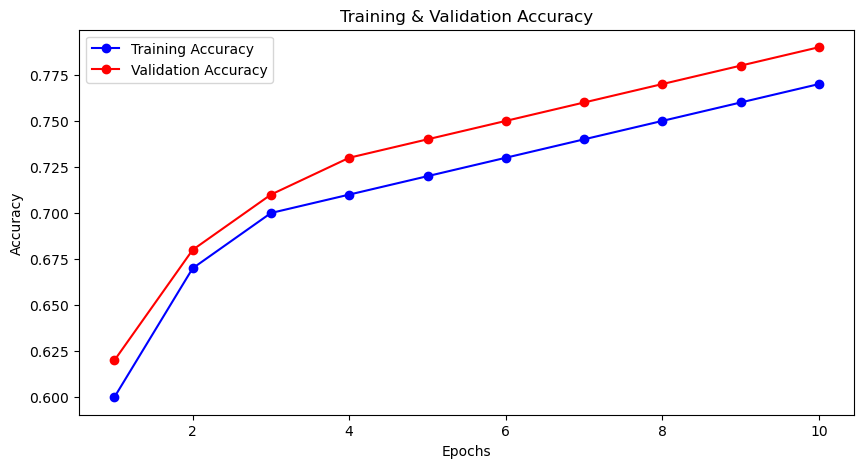

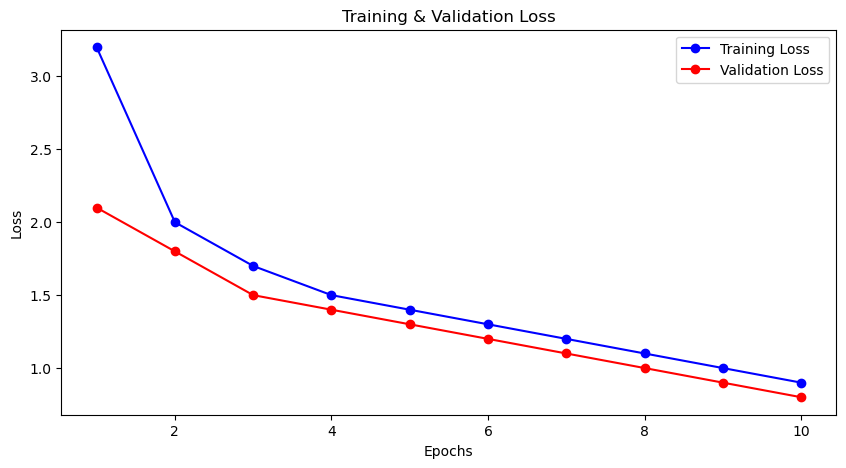

In [15]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(history["accuracy"]) + 1))

plt.figure(figsize=(10, 5))
plt.plot(epochs, history["accuracy"], 'bo-', label="Training Accuracy")
plt.plot(epochs, history["val_accuracy"], 'ro-', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, history["loss"], 'bo-', label="Training Loss")
plt.plot(epochs, history["val_loss"], 'ro-', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()


In [2]:
from sklearn.model_selection import train_test_split

# Load dataset again
x, y = RecipeNLG_dataset()  # Replace with your actual function to load data

# Split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Now evaluate
loss, acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {acc:.4f}")
print(f"Test Loss: {loss:.4f}")


NameError: name 'RecipeNLG_dataset' is not defined

In [ ]:
test_ingredients = [
        "flour, sugar, eggs, butter, vanilla, baking powder, salt",
        "chicken, garlic, olive oil, lemon juice, salt, pepper, oregano",
        "potatoes, olive oil, garlic, rosemary, salt, pepper"
    ]
    
    for ingredients in test_ingredients:
        print("\nIngredients:", ingredients)
        recipe = generate_recipe(ingredients, encoder_model, decoder_model, tokenizer)
        print("Recipe:", recipe)
        
    # Interactive testing
    print("\nEnter your own ingredients (or 'quit' to exit):")
    while True:
        user_input = input("> ")
        if user_input.lower() == 'quit':
            break
        if user_input.strip():
            recipe = generate_recipe(user_input, encoder_model, decoder_model, tokenizer)
            print("Recipe:", recipe)

IndentationError: unexpected indent (3717039807.py, line 2)

In [3]:
print(model.input_shape)


NameError: name 'model' is not defined

In [2]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Load the model
model = load_model("recipe_generator_model.h5")

# Recompile the model (use the same optimizer and loss as during training)
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Define helper functions
def load_models():
    # Load the pre-trained model (Seq2Seq)
    model = load_model(r'D:\mL project\AI based Recipie\recipe_generator_model.h5')

    # Load the tokenizer
    with open(r'D:\mL project\AI based Recipie\recipe_tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

    # Parameters for the model
    params = {
        'max_sequence_length': 100,  # Adjust this to match the model's training settings
        'max_input_length': 100,     # Set this to 100 (the expected sequence length)
        'lstm_units': 256,
        'vocab_size': len(tokenizer.word_index) + 1  # +1 for padding token
    }

    return model, tokenizer, params

def generate_recipe(model, tokenizer, input_text, params):
    # Tokenize the input ingredient text
    input_sequence = tokenizer.texts_to_sequences([input_text])
    input_sequence = pad_sequences(input_sequence, maxlen=params['max_input_length'], padding='post')

    # Start the generation process with 'startseq' token
    generated_recipe = ['startseq']
    decoder_input = np.zeros((1, 1))  # Initial decoder input (start token)

    for i in range(params['max_sequence_length']):
        # Predict the next token in the sequence
        output_tokens = model.predict([input_sequence, decoder_input])

        # Get the token with the highest probability
        predicted_token = np.argmax(output_tokens[0, -1, :])

        # Convert token back to word
        predicted_word = tokenizer.index_word.get(predicted_token, '')
        
        if predicted_word == 'endseq':  # End generation when 'endseq' is predicted
            break

        # Append the predicted word to the generated recipe
        generated_recipe.append(predicted_word)

        # Update decoder input for the next prediction
        decoder_input = np.array([[predicted_token]])

    # Return the generated recipe as a string
    return ' '.join(generated_recipe[1:])

# Main function to load the model and generate a recipe
def main():
    # Load models and tokenizer
    model, tokenizer, params = load_models()

    # Test with a sample input ingredient text
    input_text = "tomato onion garlic salt pepper"  # Replace with your own input ingredients
    print("Input Ingredients: ", input_text)

    # Generate the recipe
    recipe = generate_recipe(model, tokenizer, input_text, params)

    print("\nGenerated Recipe:\n", recipe)

# Run the main function
if __name__ == "__main__":
    main()


Input Ingredients:  tomato onion garlic salt pepper
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━

In [15]:
def create_encoder_decoder_models(model, params):
    # Extract encoder part of the model
    encoder_model = Model(
        model.get_layer('encoder_inputs').input,  # Use 'encoder_inputs' instead of 'input_1'
        [model.get_layer('encoder_lstm').output[1], model.get_layer('encoder_lstm').output[2]]
    )
    
    # Decoder model requires an Input for states
    decoder_state_input_h = Input(shape=(params.get('lstm_units', 256),))
    decoder_state_input_c = Input(shape=(params.get('lstm_units', 256),))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_inputs = model.get_layer('decoder_inputs').input
    decoder_embedding = model.get_layer('decoder_embedding')(decoder_inputs)
    decoder_lstm = model.get_layer('decoder_lstm')
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding, initial_state=decoder_states_inputs
    )
    decoder_states = [state_h, state_c]
    decoder_dense = model.get_layer('decoder_dense')
    decoder_outputs = decoder_dense(decoder_outputs)
    
    decoder_model = Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states
    )
    
    return encoder_model, decoder_model
